In [1]:
#@title Print TF version and GPU stats
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name), '', sep='\n')
!nvidia-smi

TensorFlow version: 2.4.0
Found GPU at: /device:GPU:0

Sun Jan 10 14:13:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    57W / 149W |    133MiB / 11441MiB |      3%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Set parameters:

*   window_size is a multiple of 78 and less than 450

*   it was decided that foreast time is equial to 500

*   num_epochs = 10, 30, 50

*   batch_size = 64, 128, 256

In [47]:
window_size   = 156
forecast_time = 500
num_epochs    = 10
batchsize     = 128

# Loading existed data (We decided to predict data by ourselves, so do not use it)

In [ ]:
data = pd.read_csv("/content/normalized_lorenz_0.01.csv")

FileNotFoundError: ignored

In [ ]:
data.values

AttributeError: ignored

# Alternative data: integrate Lorenz system

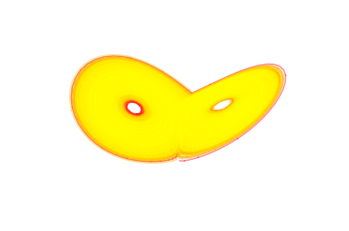

In [4]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Lorenz paramters and initial conditions
sigma, beta, rho = 10, 2.667, 28
u0, v0, w0 = 0, 1, 1.05

# Maximum time point and total number of time points
tmax, n = 6000, 600000

def lorenz(X0, t, sigma, beta, rho):
    """The Lorenz equations."""
    x, y, z = X0
    xp = sigma * (y - x)
    yp = x * (rho - z) - y
    zp =  x * y - beta * z
    return xp, yp, zp

# Integrate the Lorenz equations on the time grid t
t = np.linspace(0, tmax, n)
f = odeint(lorenz, (u0, v0, w0), t, args=(sigma, beta, rho))
x, y, z = f.T

# Plot the Lorenz attractor using a Matplotlib 3D projection
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make the line multi-coloured by plotting it in segments of length s which
# change in colour across the whole time series.
s = 10
c = np.linspace(0,1,n)
for i in range(0,n-s,s):
    ax.plot(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1], color=(1,c[i],0), alpha=0.4)

# Remove all the axis clutter, leaving just the curve.
ax.set_axis_off()

plt.show()

In [5]:
from scipy import stats
x = stats.zscore(x)
y = stats.zscore(y)
z = stats.zscore(z)

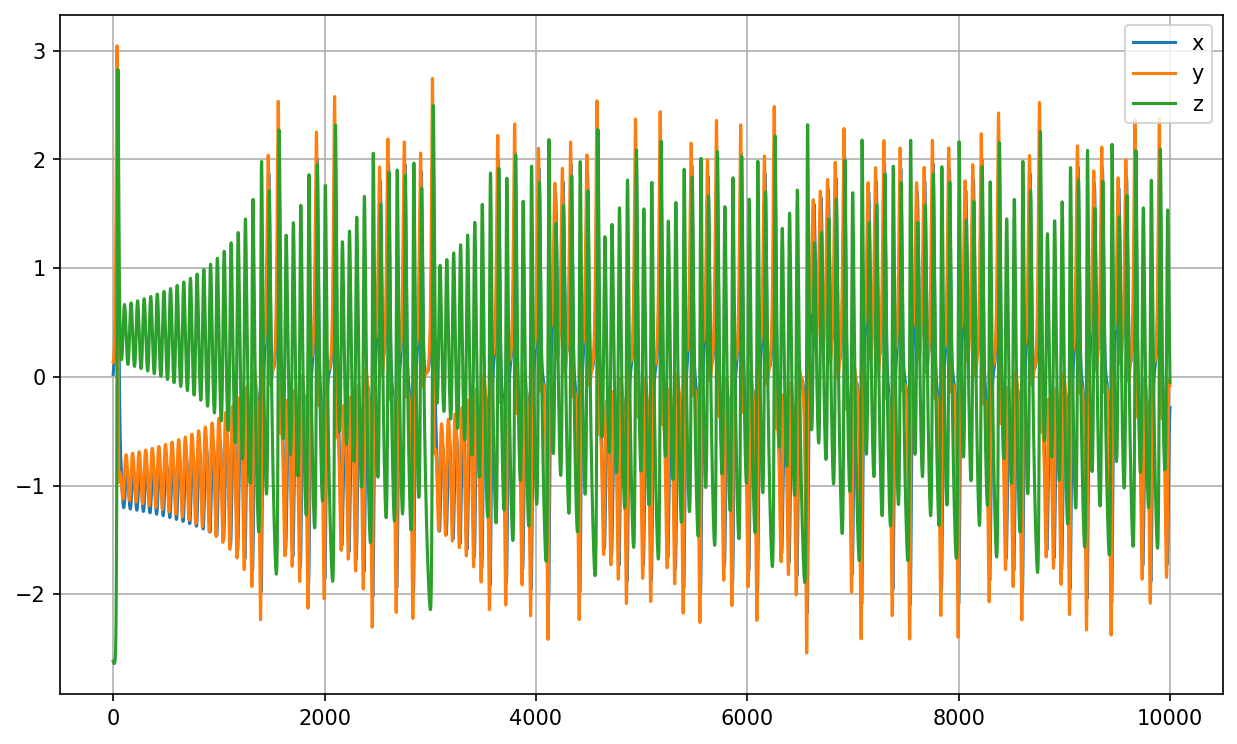

In [6]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x[:10000], label='x')
plt.plot(y[:10000], label='y')
plt.plot(z[:10000], label='z')
plt.legend()
plt.grid(True)

In [7]:
data = np.array([x,y,z])
data = np.transpose(data)

# Create dataset

In [8]:
data.shape

(600000, 3)

In [9]:
def split_sequence(sequence, n_steps):
    X, Y = list(), list()
    for i in range(0, len(sequence)-1):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix,:], sequence[end_ix,:]
        X.append(seq_x)
        Y.append(seq_y)
    return np.array(X), np.array(Y)

In [10]:
X, Y = split_sequence(data, window_size)
end_train = int(np.round(X.shape[0]*0.7))
end_valid = int(np.round(X.shape[0]*(0.7+0.2)))
train_X = X[:end_train]
train_Y = Y[:end_train]
valid_X = X[end_train:end_valid]
valid_Y = Y[end_train:end_valid]
test_X = X[end_valid:]
test_Y = Y[end_valid:]

In [11]:
#@title Shapes
print('Train X shape - ', train_X.shape, ' train Y shape - ', train_Y.shape)
print('Valid X shape - ', valid_X.shape, '  valid Y shape - ', valid_Y.shape)
print('Test  X shape - ', test_X.shape, '   test Y shape  - ', test_Y.shape)

Train X shape -  (419891, 156, 3)  train Y shape -  (419891, 3)
Valid X shape -  (119969, 156, 3)   valid Y shape -  (119969, 3)
Test  X shape -  (59984, 156, 3)    test Y shape  -  (59984, 3)


# RNN model creation and trainig

We decided to compare the following architectures:



*   one layer with 32 cells
*   two layers with 32 cells
*   three layers with 32 cells
*   one layer with 312 cells



In [18]:
from keras import Model, layers, Input
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import EarlyStopping

In [19]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [27]:
es = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=1, mode='min', baseline=None, restore_best_weights=False)

In [28]:
def build_lstm_model(input_shape, summary=True):
  
    inputs = Input(shape=input_shape)
    
    # If one layer use:
    # x = layers.LSTM(32, activation='tanh', dropout=.2)(inputs)

    # I two layers use:
    x = layers.LSTM(32, activation='tanh', dropout=.2, return_sequences=True)(inputs)
    x = layers.LSTM(32, activation='tanh', dropout=.2)(x)


    # If three layers use:
    # x = layers.LSTM(32, activation='tanh', dropout=.2, return_sequences=True)(inputs)
    # x = layers.LSTM(32, activation='tanh', dropout=.2, return_sequences=True)(x)
    # x = layers.LSTM(32, activation='tanh', dropout=.2)(x)

    output = layers.Dense(3)(x)
    
    model = Model(inputs=inputs, outputs=output, name="lstm_model")
    model.compile(loss=root_mean_squared_error,
                optimizer="RMSprop",
                metrics=['accuracy'])
    if summary:
        print(model.summary())
    
    return model
    

In [29]:
lstm_model = build_lstm_model((window_size,3))

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 156, 3)]          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 156, 32)           4608      
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 13,027
Trainable params: 13,027
Non-trainable params: 0
_________________________________________________________________
None


Training

In [30]:
tf.keras.backend.clear_session()
lstm_history = lstm_model.fit(train_X, train_Y, 
                              epochs=num_epochs, 
                              batch_size=batchsize, 
                              validation_data=(valid_X, valid_Y), 
                              shuffle=True,
                              callbacks=[es])

Epoch 1/10
3281/3281 [==============================] - 211s 62ms/step - loss: 0.1201 - accuracy: 0.9288 - val_loss: 0.1300 - val_accuracy: 0.9315
Epoch 2/10
3281/3281 [==============================] - 202s 61ms/step - loss: 0.0546 - accuracy: 0.9687 - val_loss: 0.1352 - val_accuracy: 0.9391
Epoch 3/10
3281/3281 [==============================] - 201s 61ms/step - loss: 0.0414 - accuracy: 0.9759 - val_loss: 0.1516 - val_accuracy: 0.9333
Epoch 4/10
3281/3281 [==============================] - 201s 61ms/step - loss: 0.0346 - accuracy: 0.9793 - val_loss: 0.1467 - val_accuracy: 0.9356
Epoch 5/10
3281/3281 [==============================] - 200s 61ms/step - loss: 0.0307 - accuracy: 0.9812 - val_loss: 0.1296 - val_accuracy: 0.9454
Epoch 6/10
3281/3281 [==============================] - 200s 61ms/step - loss: 0.0280 - accuracy: 0.9832 - val_loss: 0.1547 - val_accuracy: 0.9308
Epoch 7/10
3281/3281 [==============================] - 201s 61ms/step - loss: 0.0261 - accuracy: 0.9841 - val_loss: 0

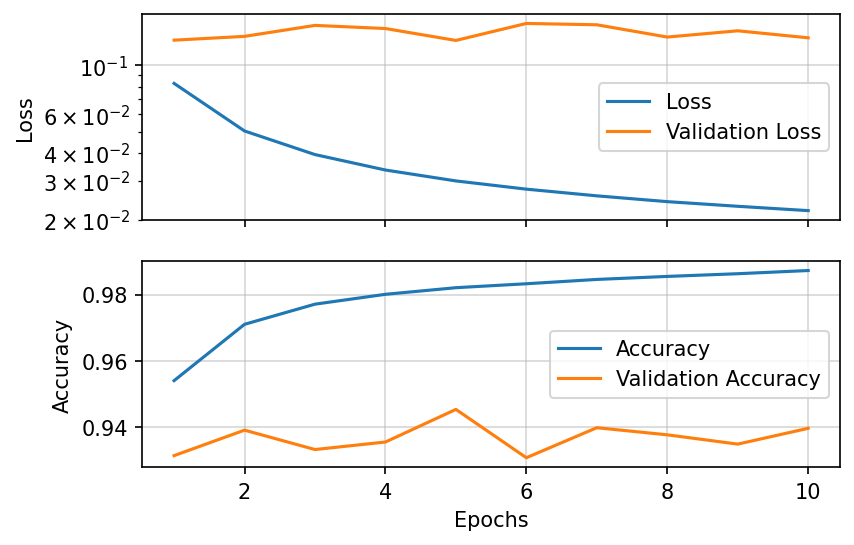

In [31]:
#@title Plot history
def plot_history(history, ylim=None):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  ax1.plot(np.array(history.epoch)+1, history.history['loss'], label='Loss')
  ax1.plot(np.array(history.epoch)+1, history.history['val_loss'], label='Validation Loss')
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_yscale('log')
  ax1.grid(alpha=.5)
  if history.history.__contains__('lr'):
    ax1b = ax1.twinx()
    ax1b.plot(history.history['lr'], 'g-', linewidth=1)
    ax1b.set_yscale('log')
    ax1b.set_ylabel('Learning Rate', color='g')

  ax2.plot(np.array(history.epoch)+1, history.history['accuracy'], label='Accuracy')
  ax2.plot(np.array(history.epoch)+1, history.history['val_accuracy'], label='Validation Accuracy')
  ax2.legend()
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.grid(alpha=.5)
  if ylim:
    ax2.set_ylim(ylim)
  #ax2.legend()
  plt.show() 

plot_history(lstm_history)

# One step ahead forecasting

In [32]:
forecast = lstm_model.predict(test_X)
print(forecast.shape)

(59984, 3)


In [33]:
errorX = root_mean_squared_error(test_Y[:, 0], forecast[:, 0]).numpy()
print('RMSE X =', errorX)
errorY = root_mean_squared_error(test_Y[:, 1], forecast[:, 1]).numpy()
print('RMSE Y =', errorY)
errorZ = root_mean_squared_error(test_Y[:, 2], forecast[:, 2]).numpy()
print('RMSE Z =', errorZ)
errorAVG = (errorX + errorY + errorZ)/3
print('Average RMSE =', errorAVG)

RMSE X = 0.07887652267744041
RMSE Y = 0.09957387620886951
RMSE Z = 0.19316878835342727
Average RMSE = 0.12387306241324574


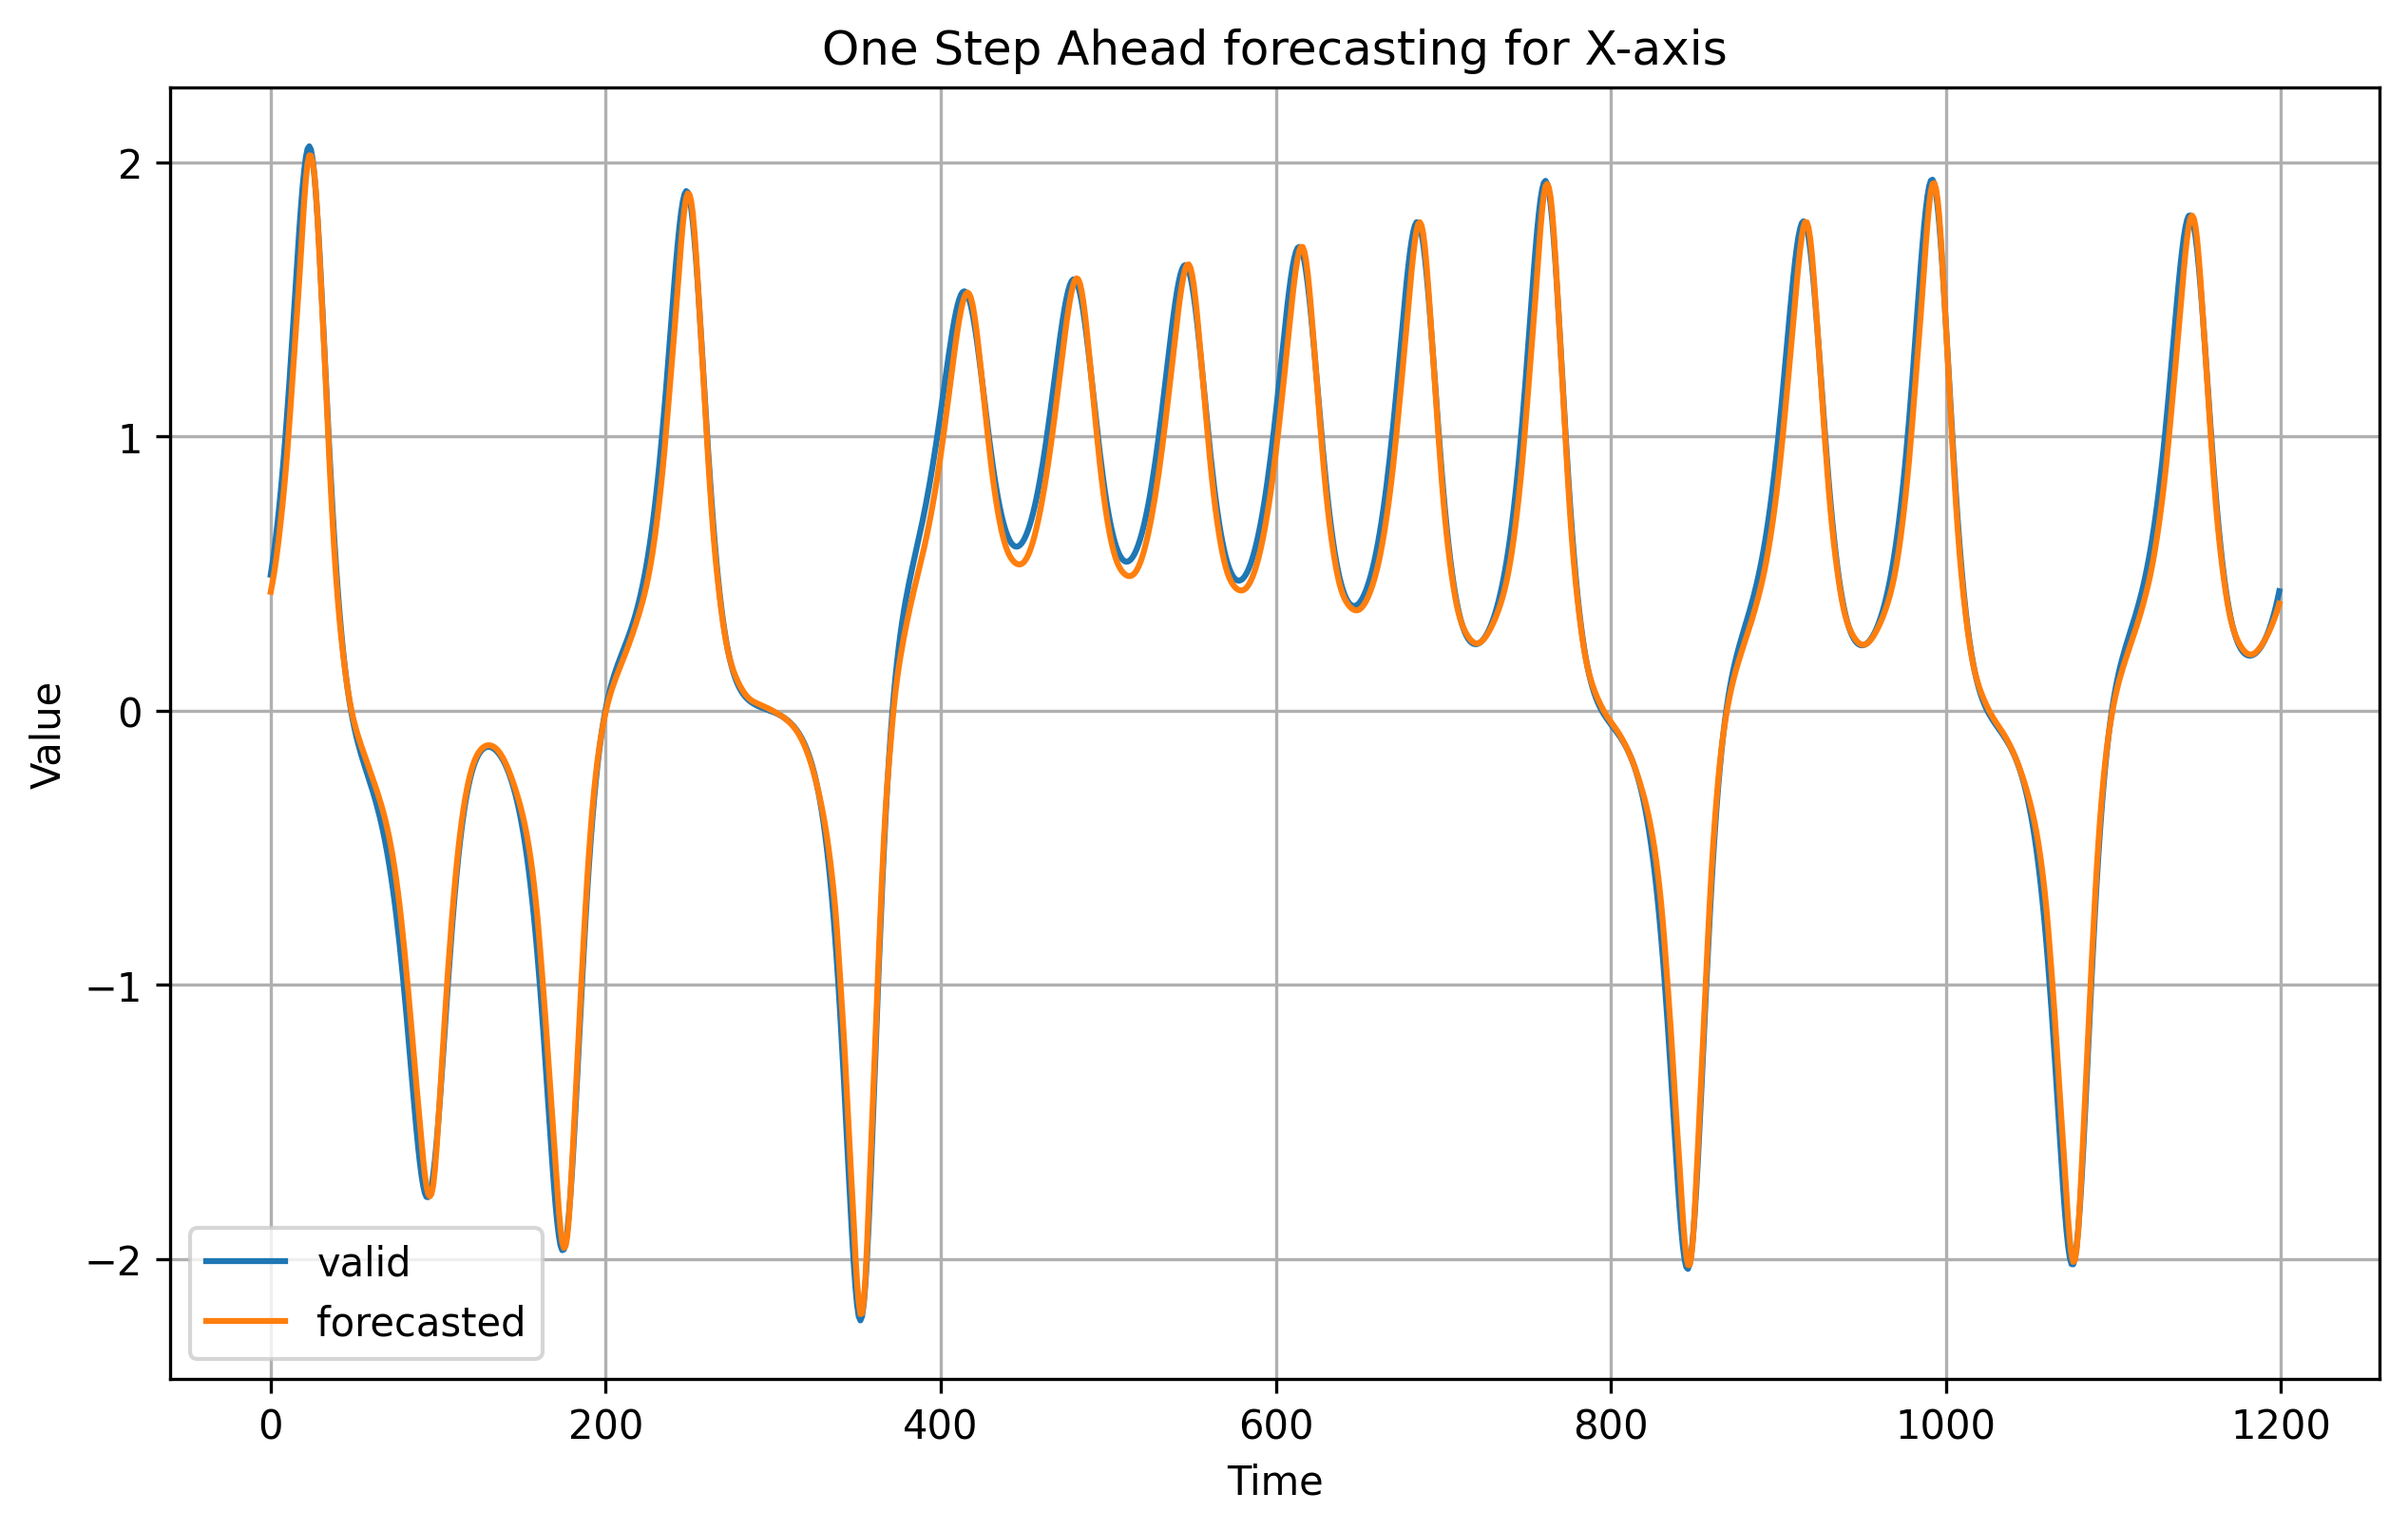

In [52]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(test_Y[:1200, 0], label='valid')
plt.plot(forecast[:1200, 0], label='forecasted')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title('One Step Ahead forecasting for X-axis')
plt.grid(True)


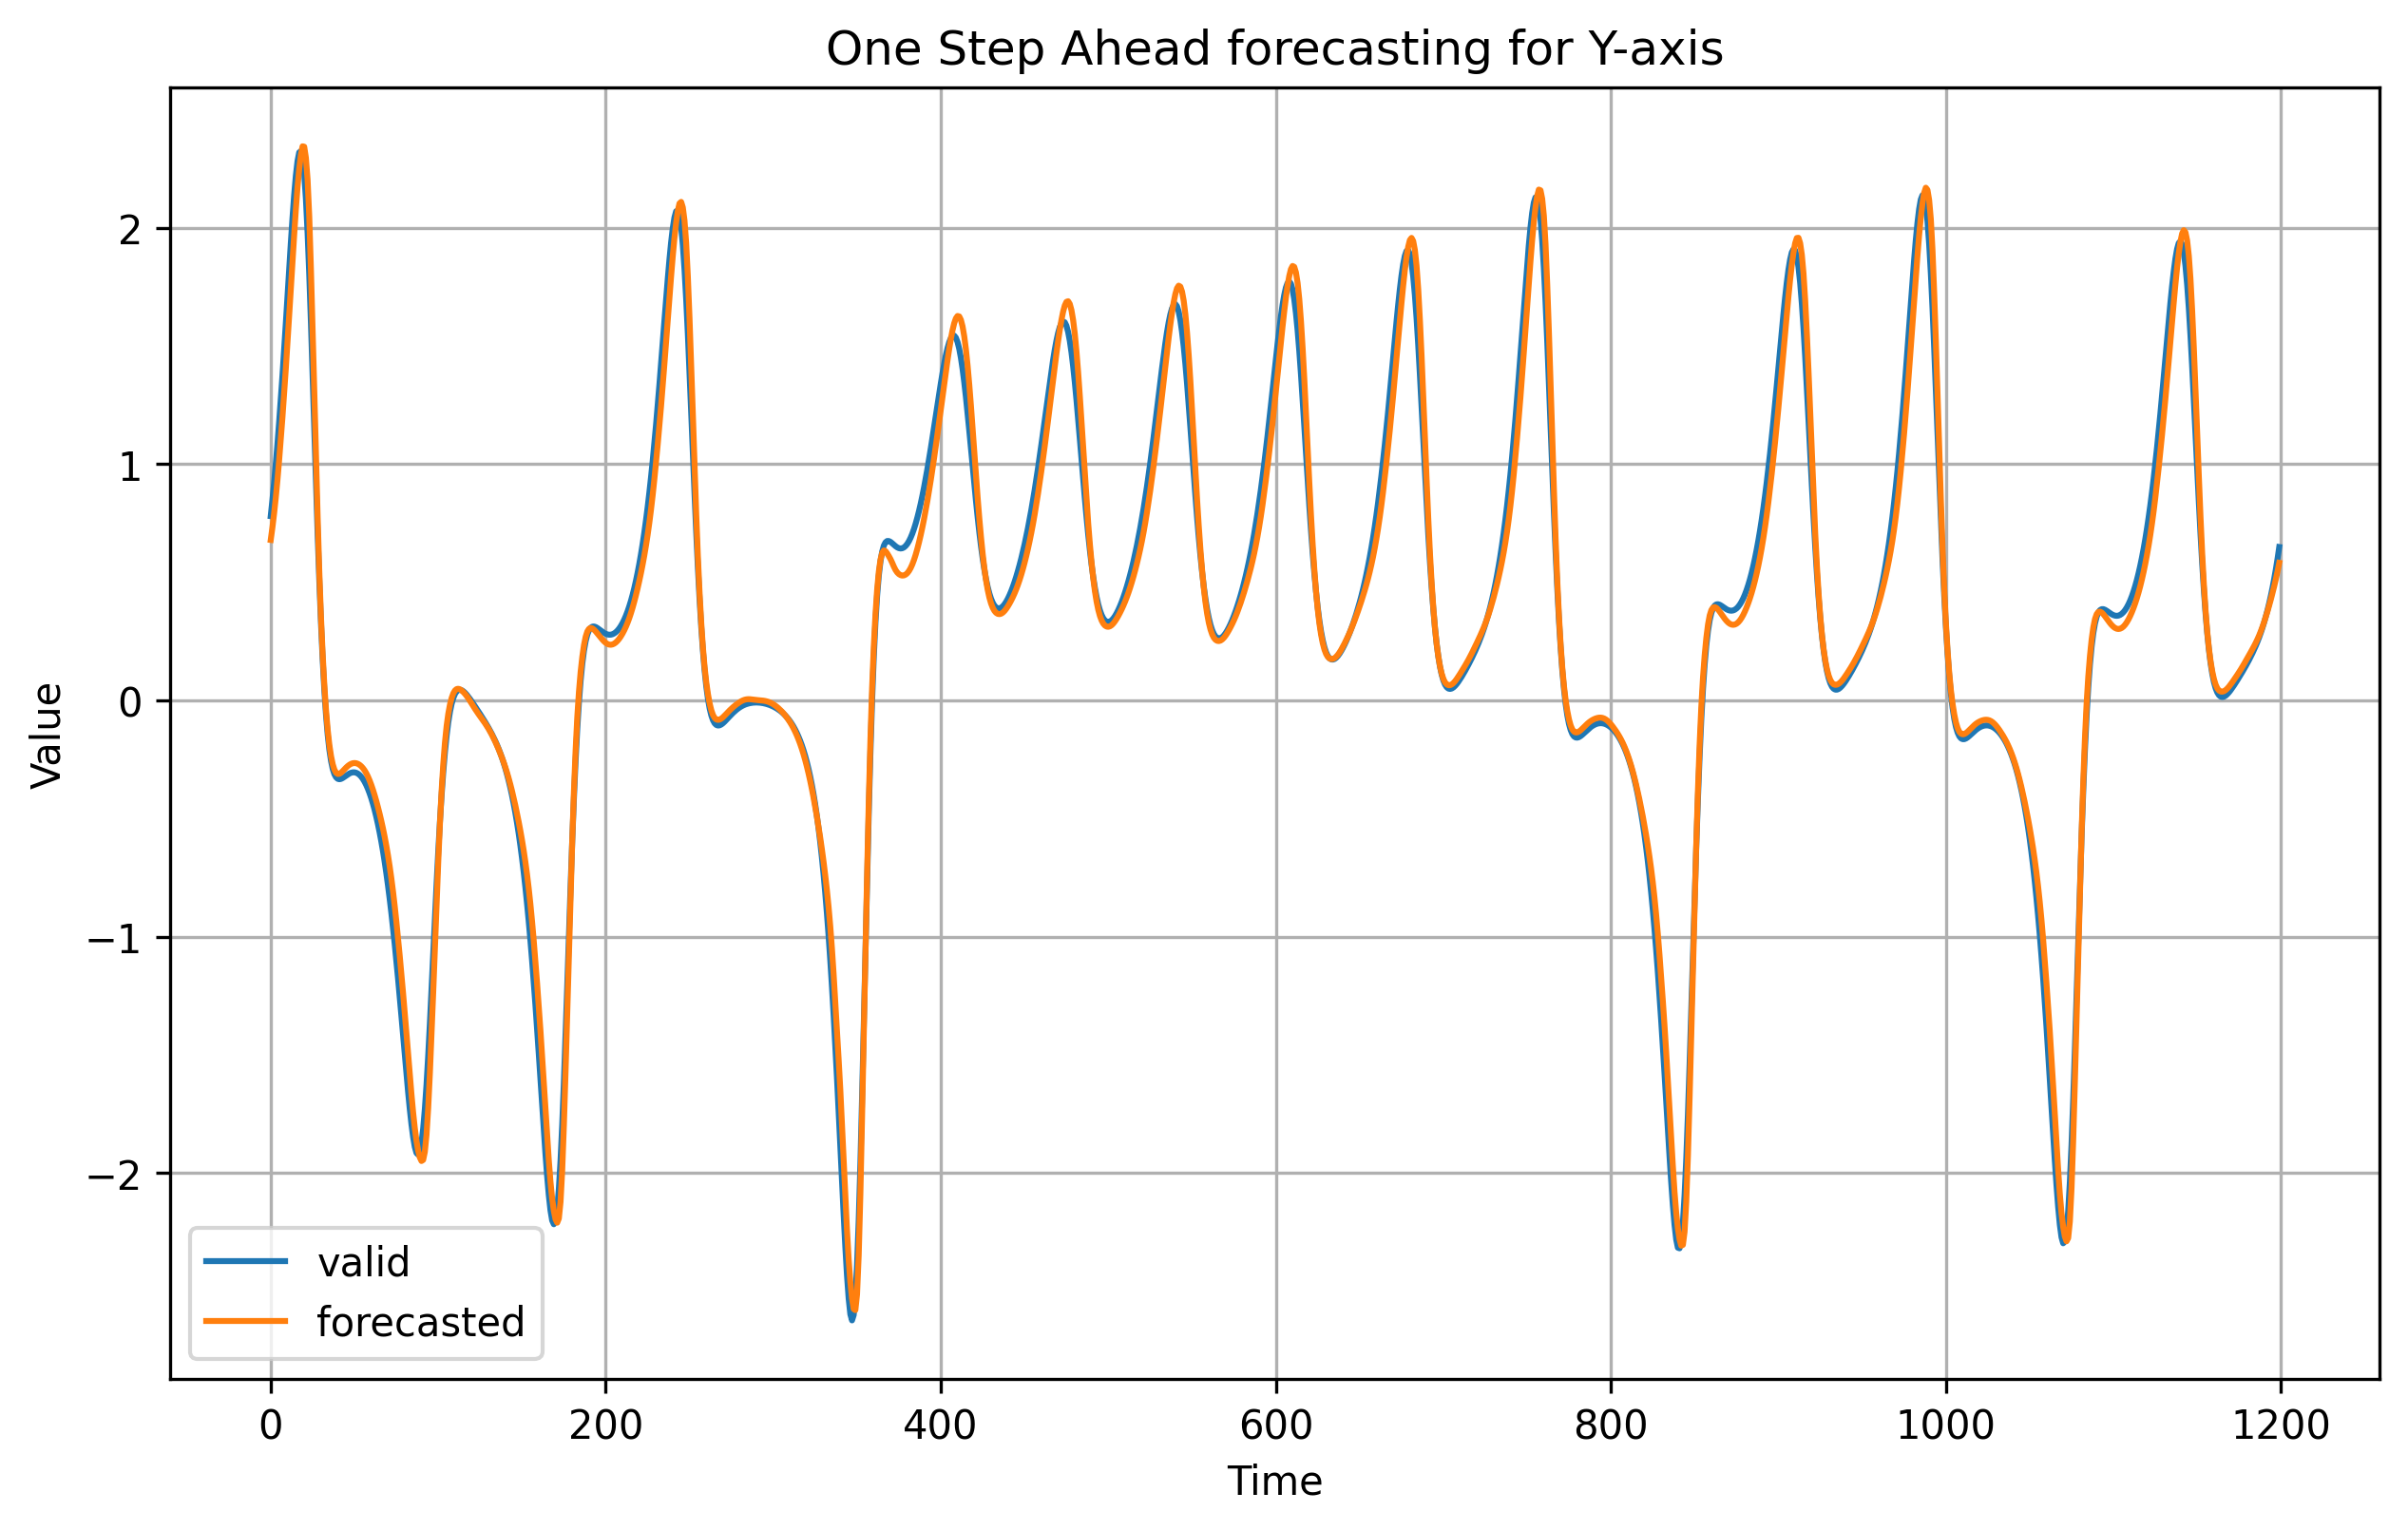

In [53]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(test_Y[:1200, 1], label='valid')
plt.plot(forecast[:1200, 1], label='forecasted')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title('One Step Ahead forecasting for Y-axis')
plt.grid(True)

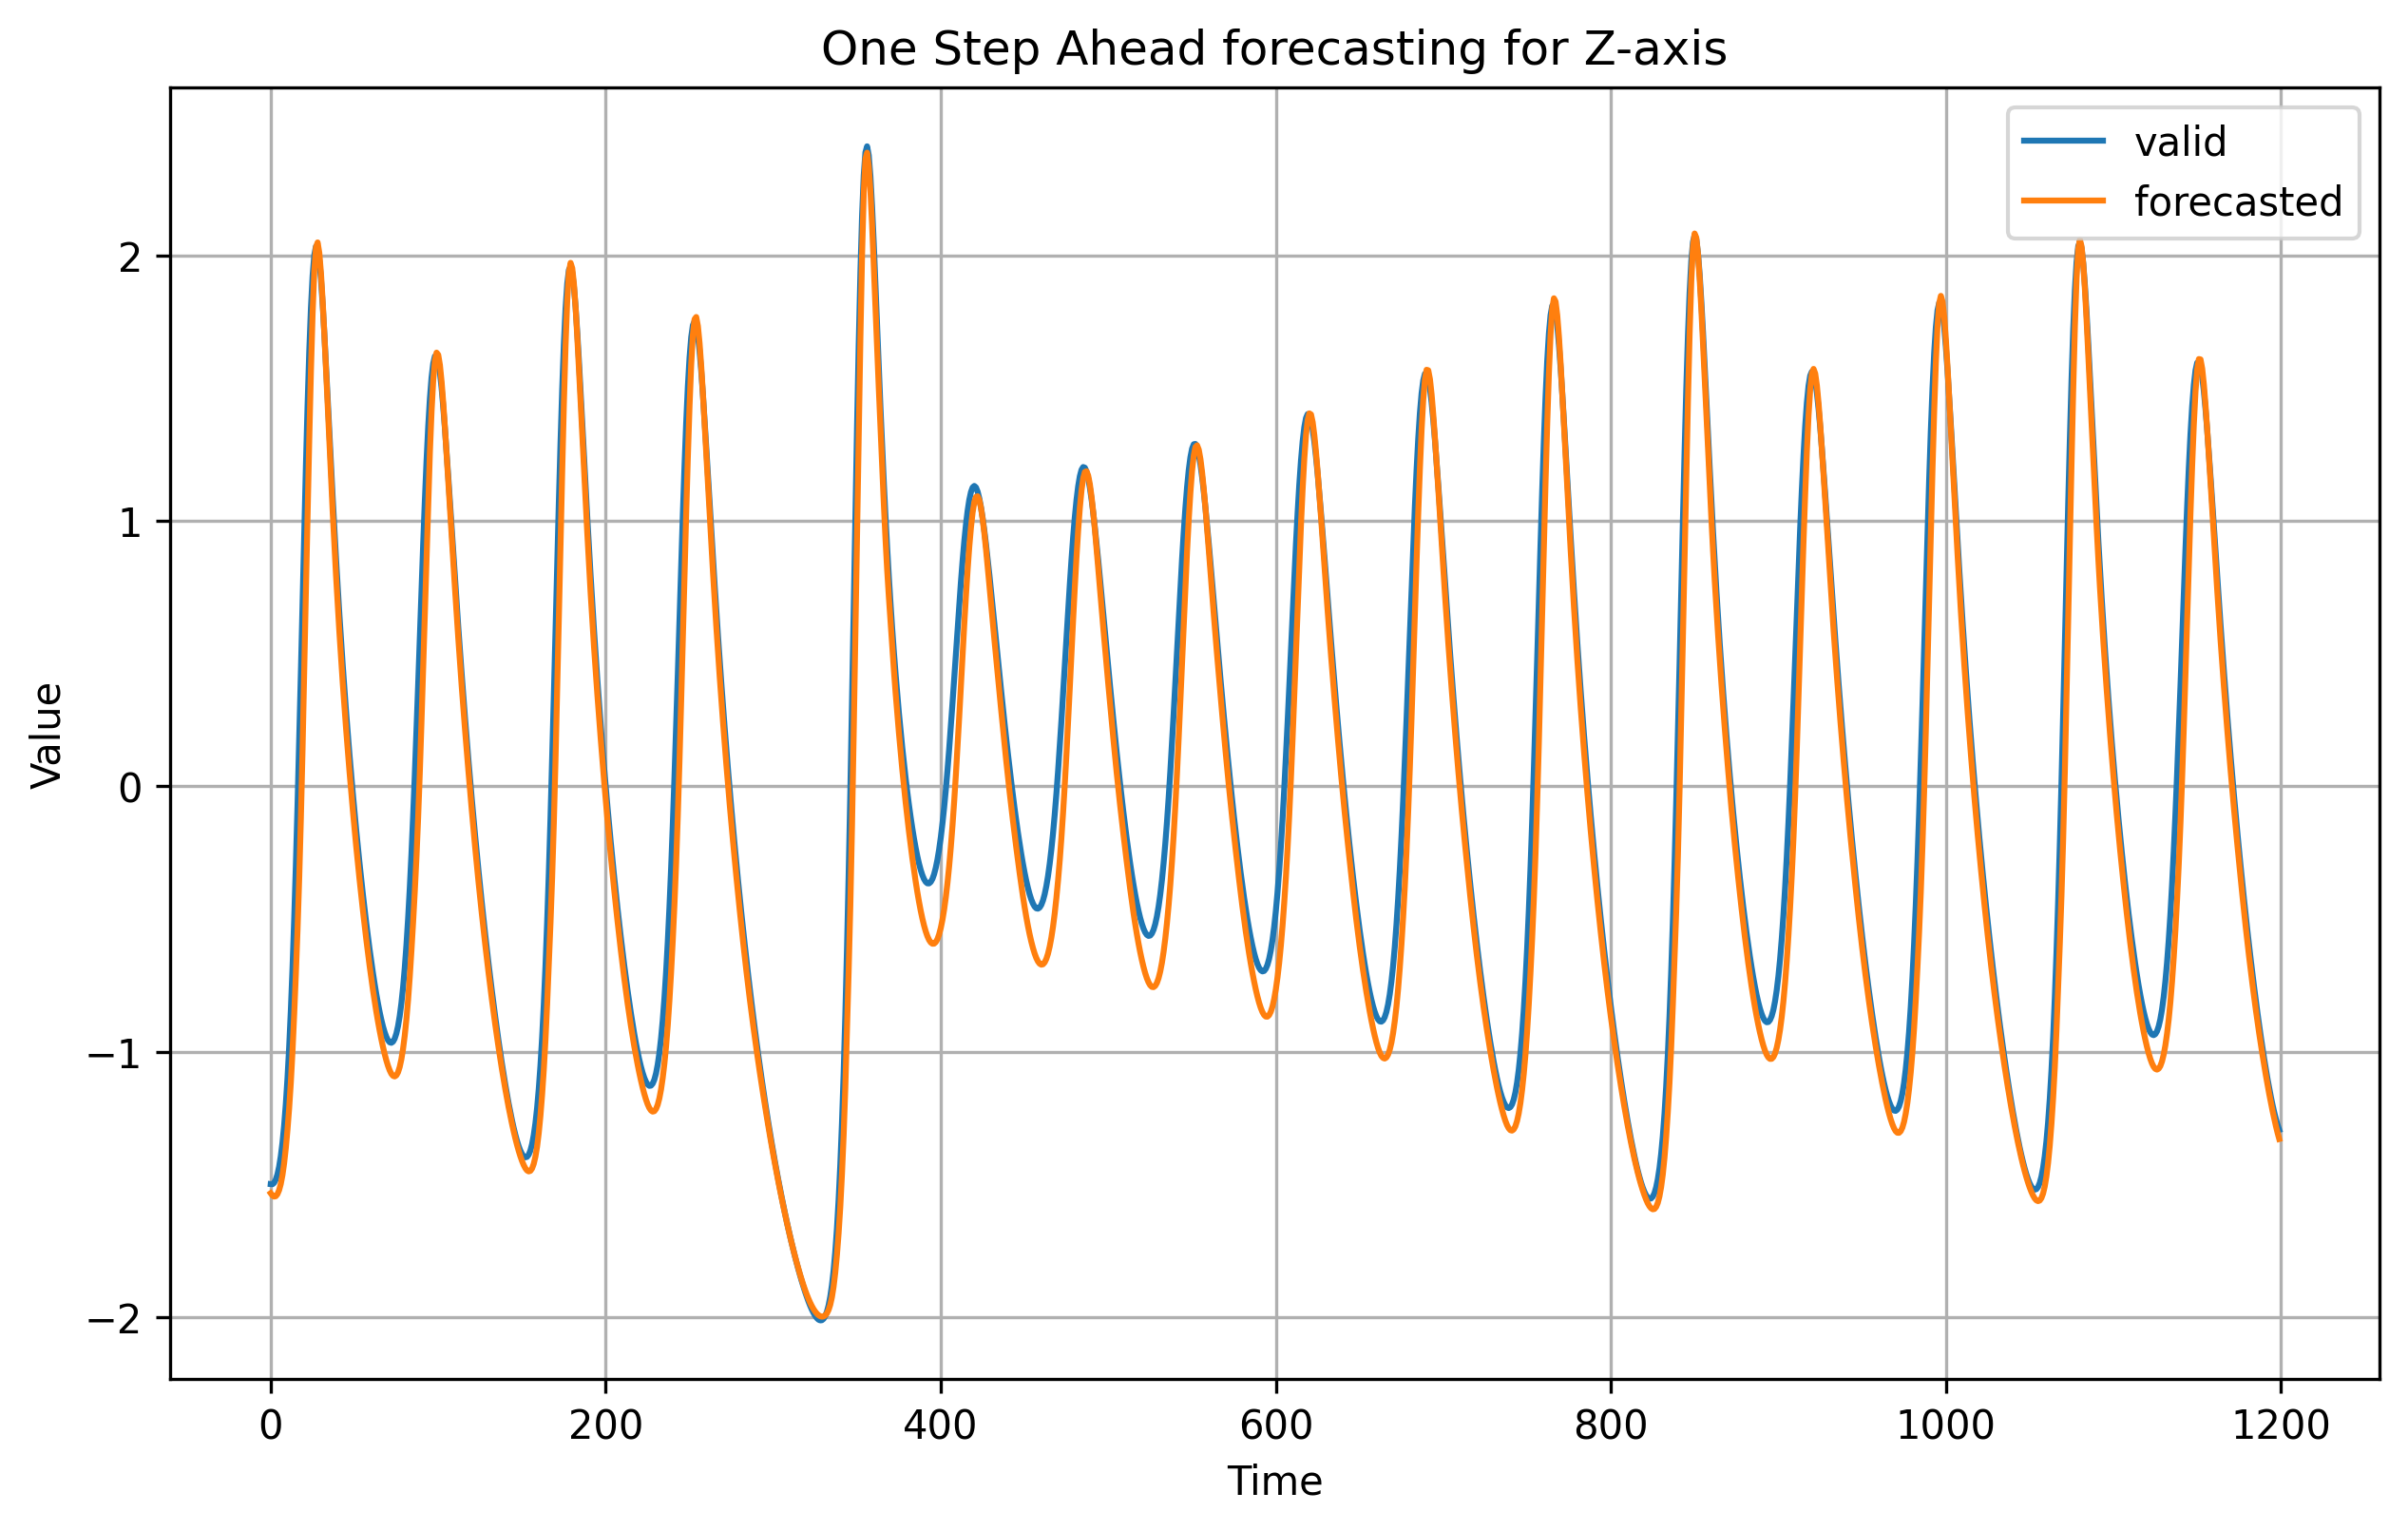

In [54]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(test_Y[:1200, 2], label='valid')
plt.plot(forecast[:1200, 2], label='forecasted')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title('One Step Ahead forecasting for Z-axis')
plt.grid(True)

# Multiple step ahead forecasting

We use values predicted by RNN to forecast multiple steps ahead

In [48]:
# forecast multiple step

def forecast_mult_step(forecast_time, window_size, X, Y, model):
  if len(test_Y) - forecast_time < window_size : # check the possibility of forecasting
    print('Choose another time')
  else:
    Y_mult = np.empty(shape=[0, 3]) # create empty array for storing forecasted Y values
    forecast_mult = test_X[:1, :, :] # copy data for the first time step prediction
    for time in range(forecast_time):
      y = model.predict(forecast_mult[time:time+1,:,:]) # predict Y value
      Y_mult = np.append(Y_mult, y, axis=0) # save Y value
      # print(y)
      forecast_mult = np.append(forecast_mult, np.empty(shape=[1, window_size, 3]), axis=0) # add new empty sample 
      forecast_mult[time+1, :window_size-1, :] = forecast_mult[time, 1:window_size, :] # copy values from previous step except the last value
      forecast_mult[time+1, window_size-1, :] = y # add predicted value

  return Y_mult
  #print(forecast_mult.shape)
  #print(Y_mult.shape)

In [49]:
Y_mult = forecast_mult_step(forecast_time, window_size, test_X, test_Y, lstm_model)

In [50]:
errorX = root_mean_squared_error(test_Y[:forecast_time, 0], Y_mult[:, 0]).numpy()
print('RMSE X =', errorX)
errorY = root_mean_squared_error(test_Y[:forecast_time, 1], Y_mult[:, 1]).numpy()
print('RMSE Y =', errorY)
errorZ = root_mean_squared_error(test_Y[:forecast_time, 2], Y_mult[:, 2]).numpy()
print('RMSE Z =', errorZ)
errorAVG = (errorX + errorY + errorZ)/3
print('Average RMSE =', errorAVG)

RMSE X = 1.4235243091286451
RMSE Y = 1.455304517814265
RMSE Z = 1.602861702575062
Average RMSE = 1.4938968431726574


Forecast for X

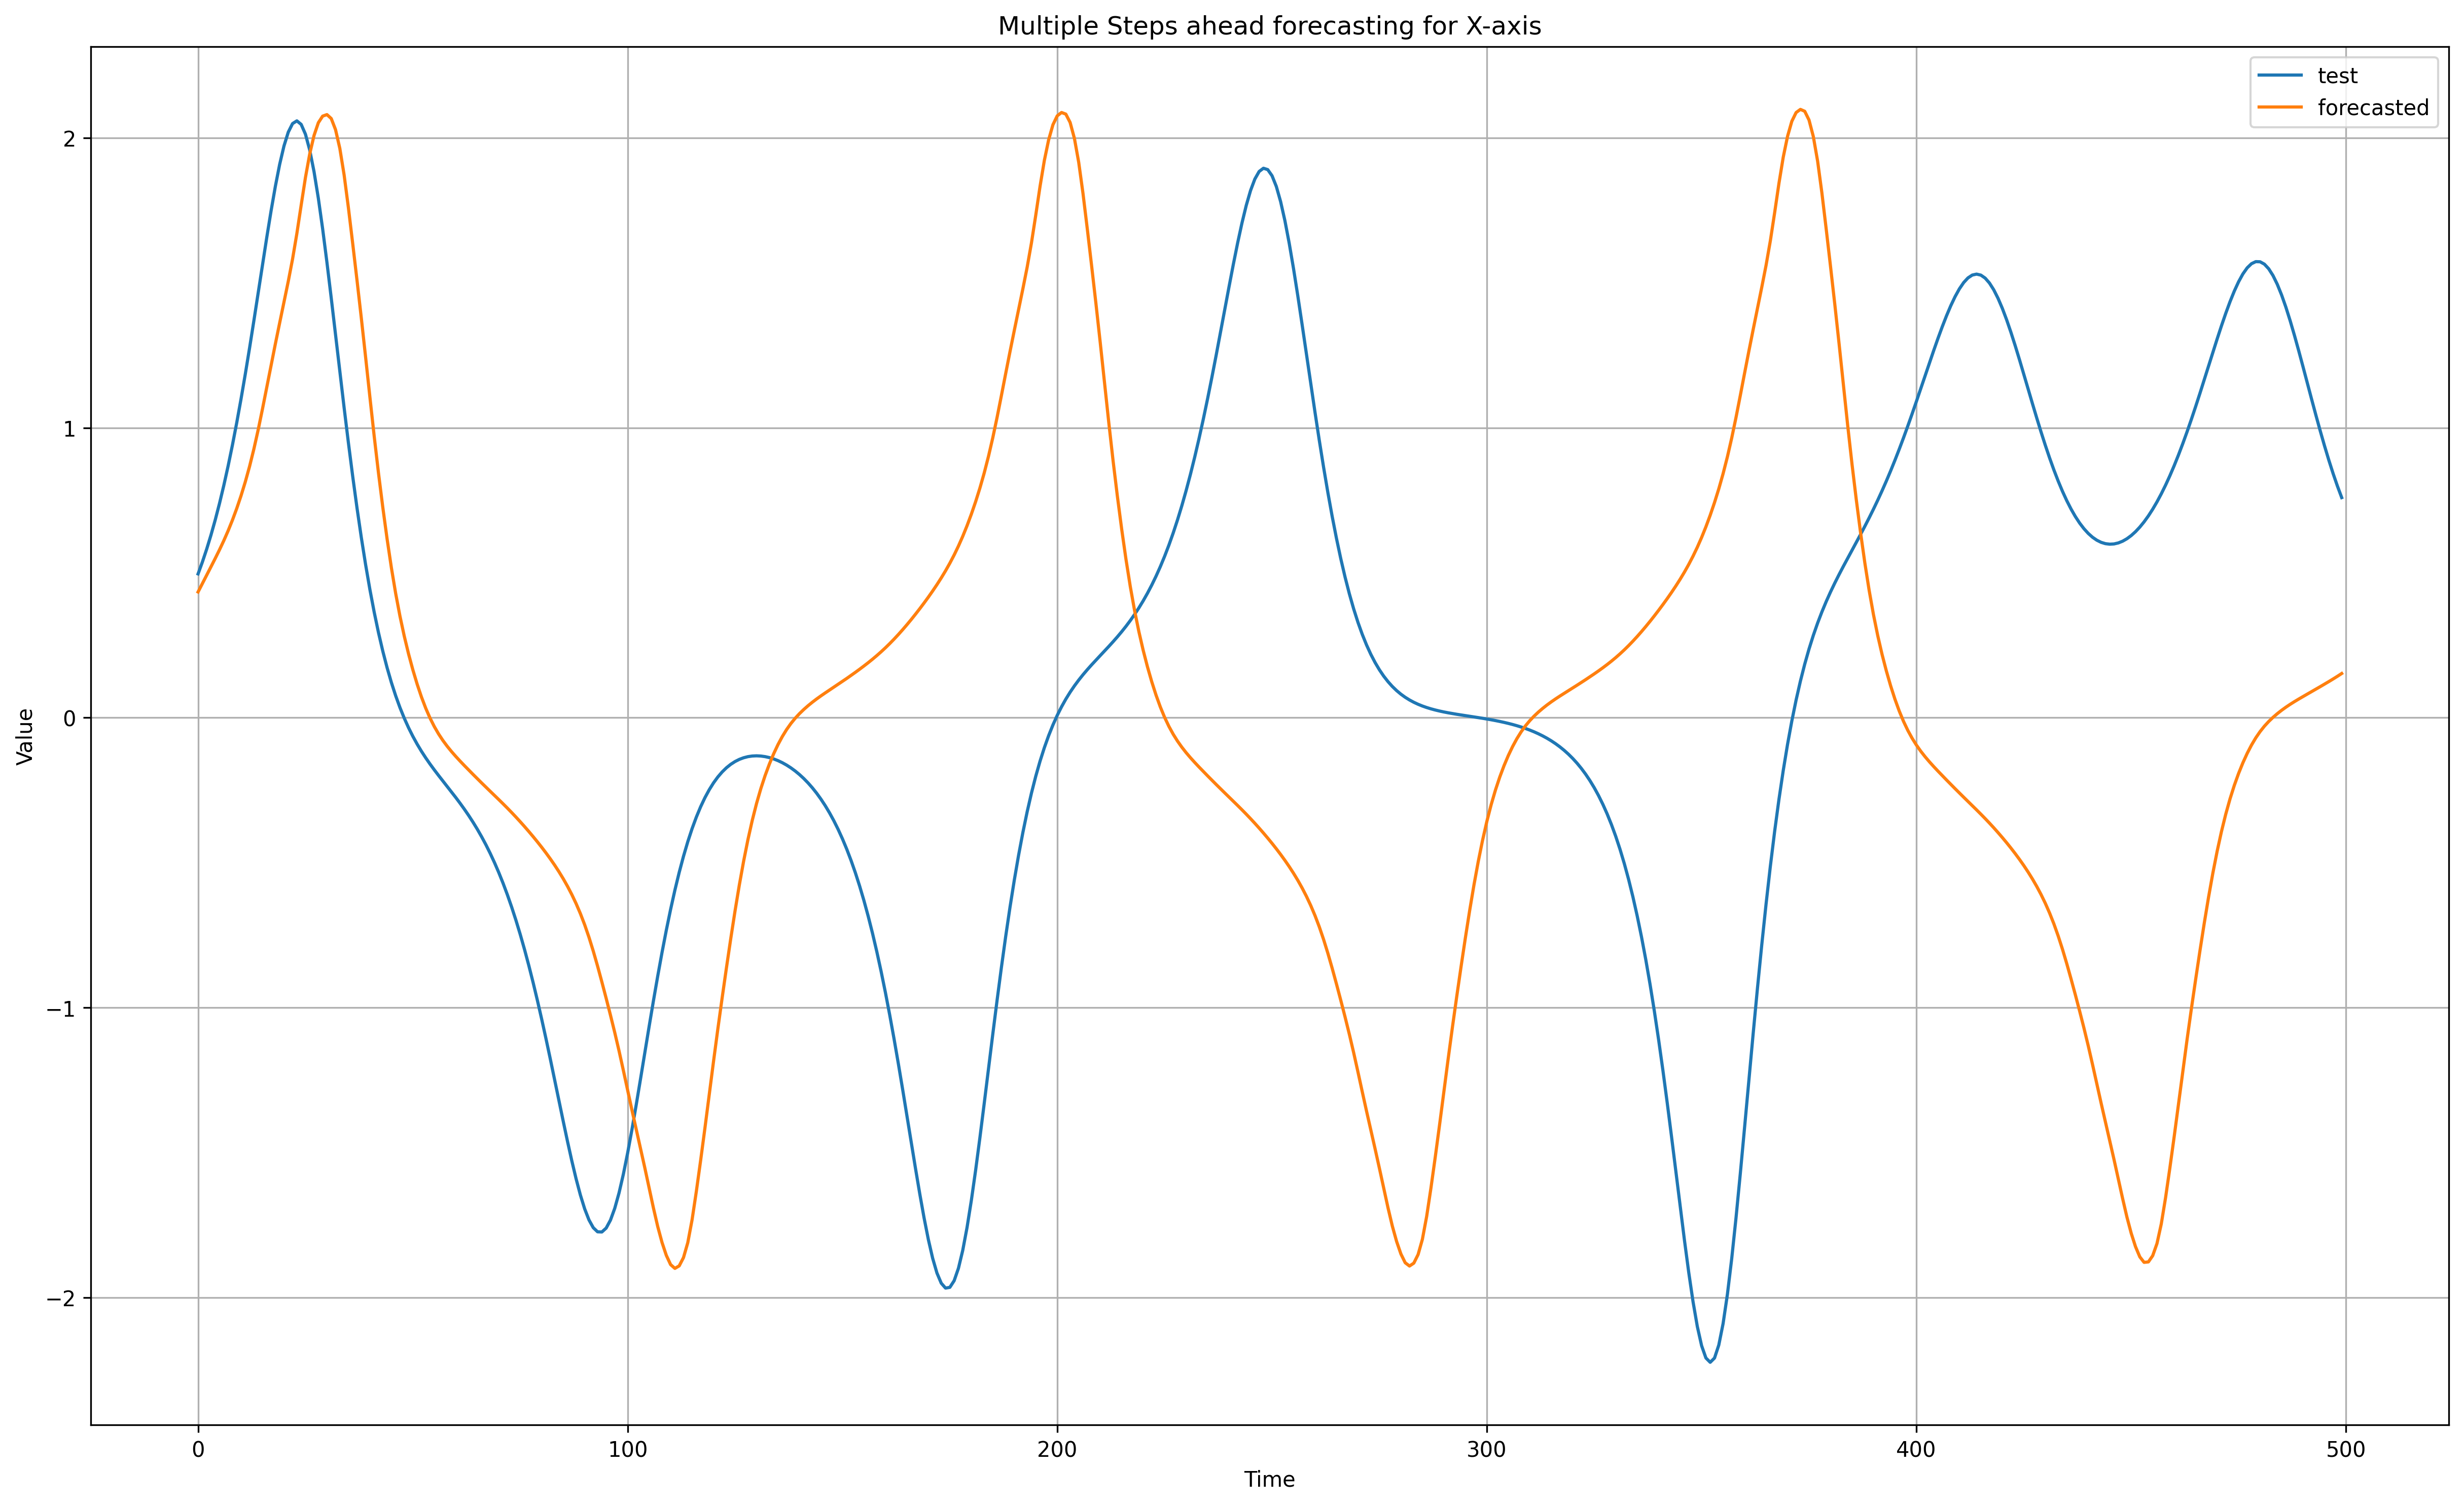

In [55]:
plt.figure(figsize=(20, 12), dpi=300)
plt.plot(test_Y[:forecast_time, 0], label='test')
plt.plot(Y_mult[:, 0], label='forecasted')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title('Multiple Steps ahead forecasting for X-axis')
plt.grid(True)

Forecast for Y

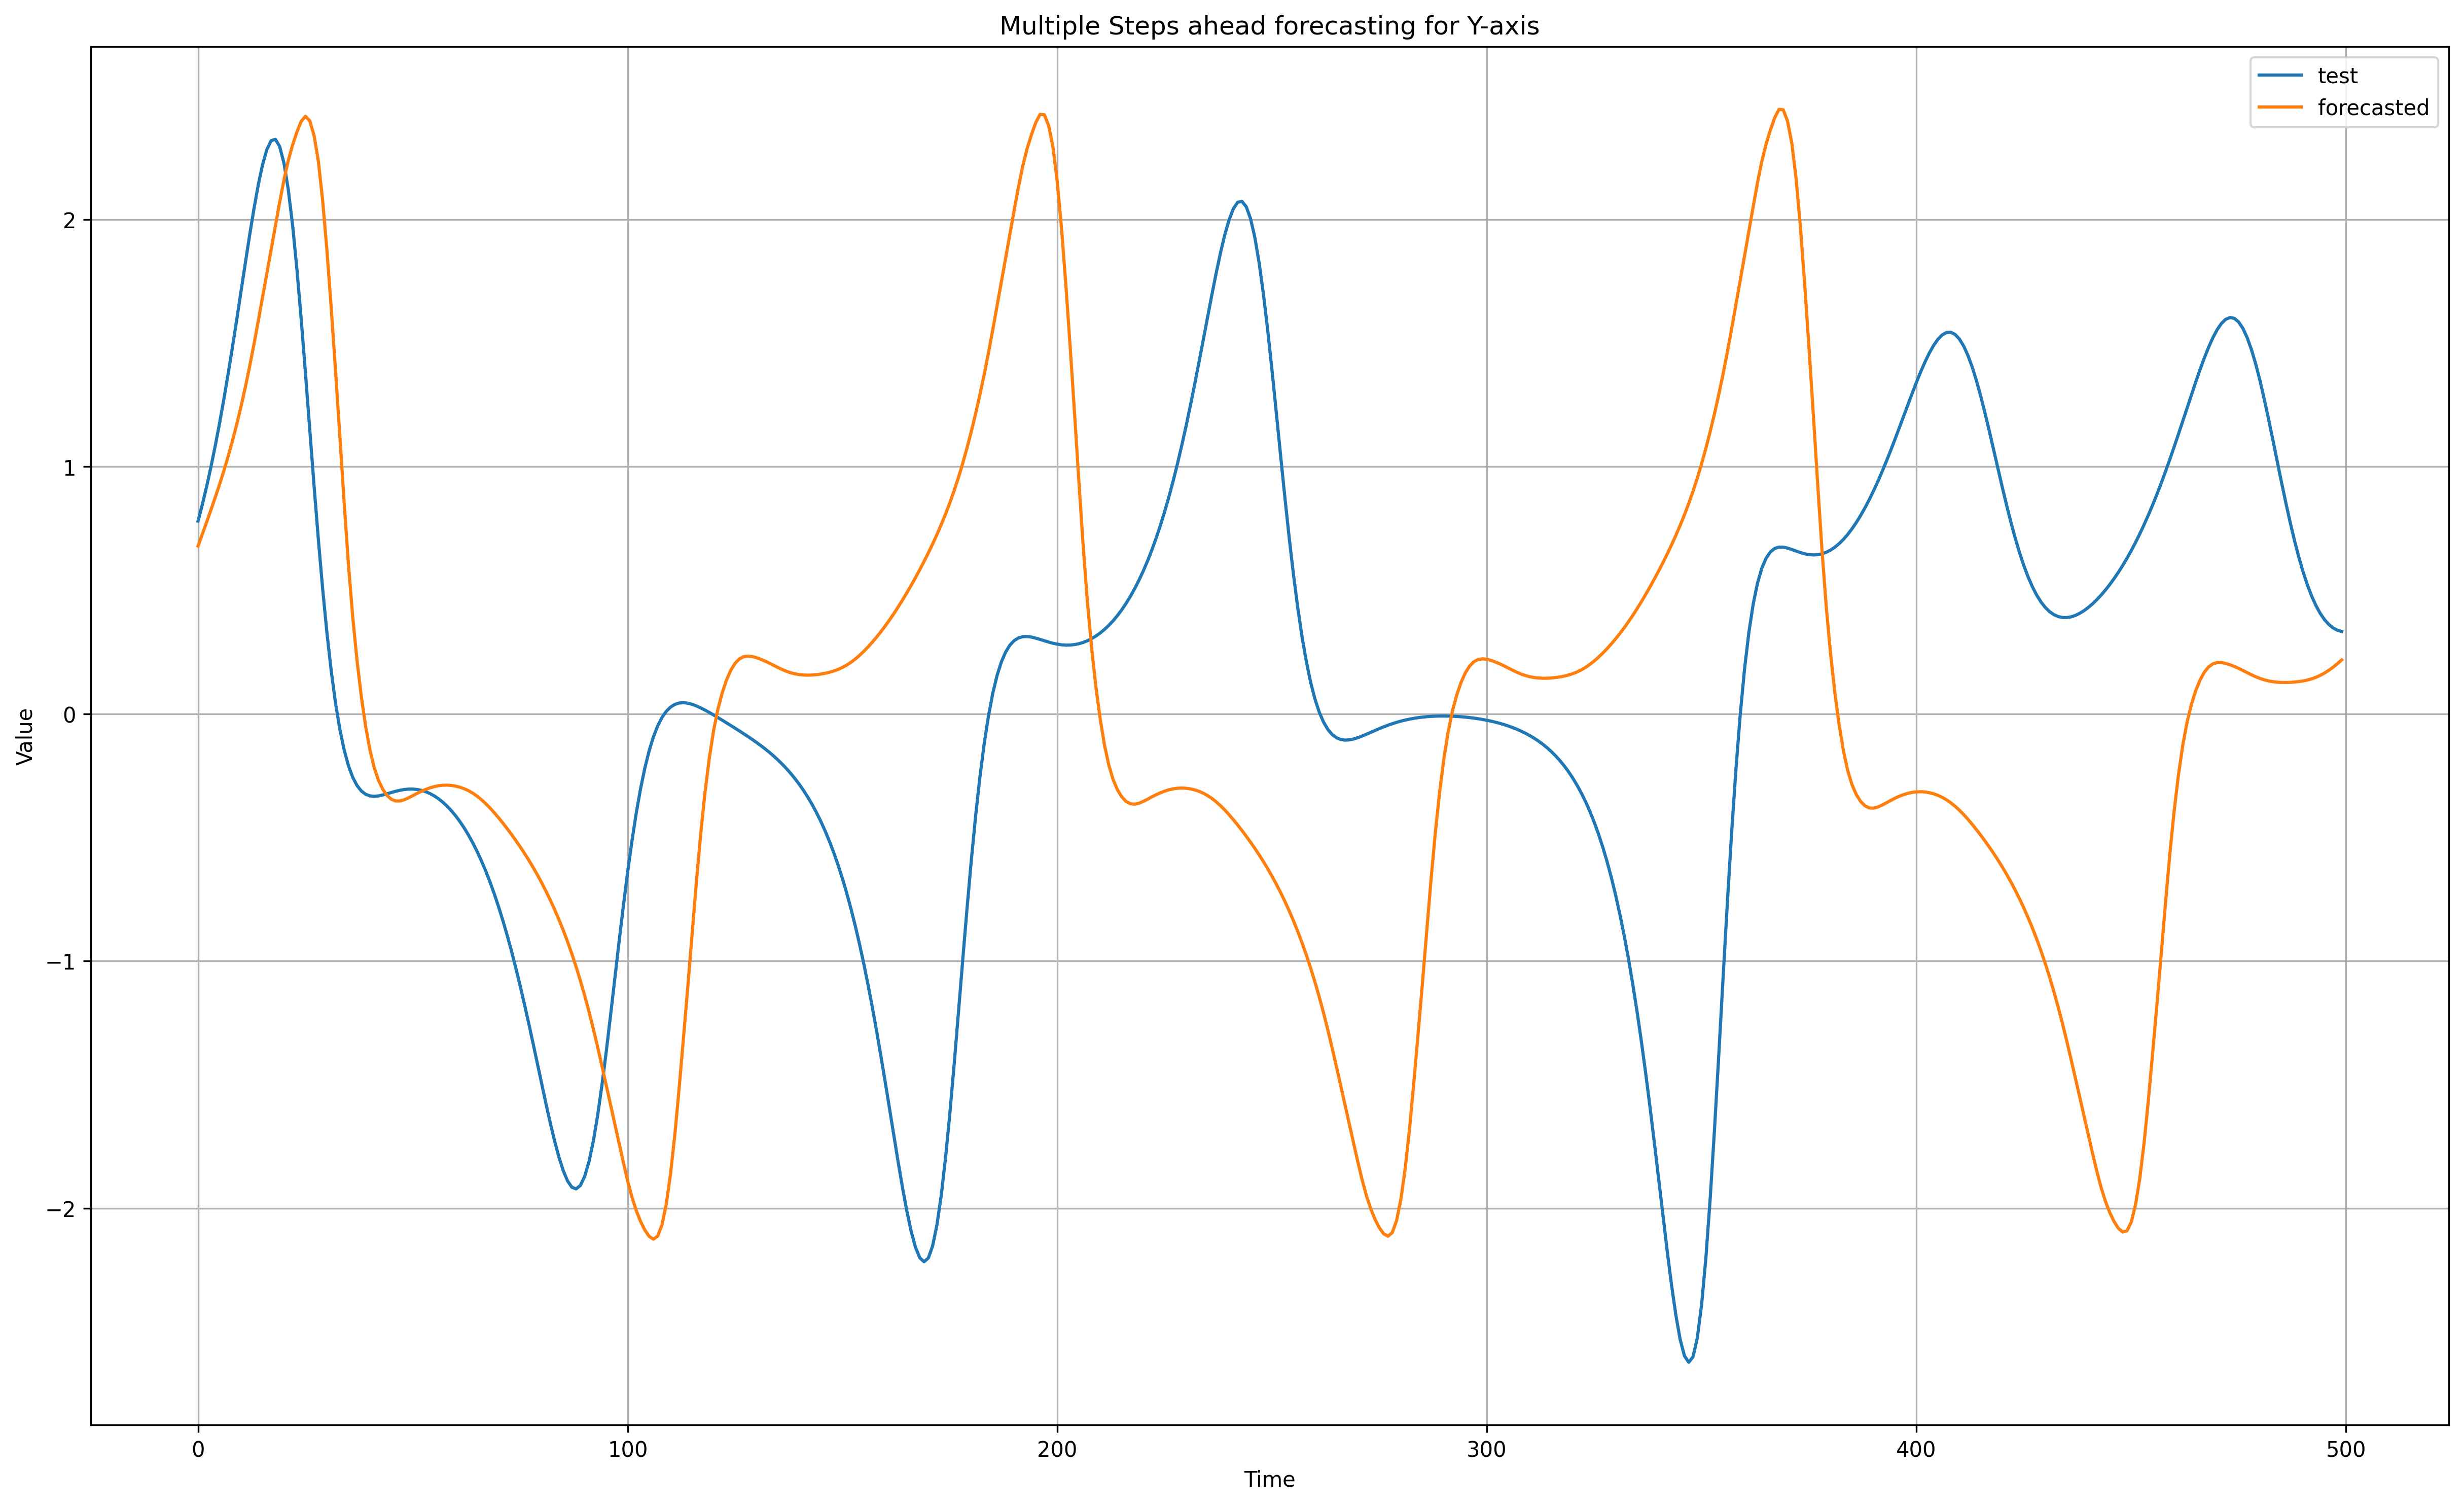

In [57]:
plt.figure(figsize=(20, 12), dpi=300)
plt.plot(test_Y[:forecast_time, 1], label='test')
plt.plot(Y_mult[:, 1], label='forecasted')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title('Multiple Steps ahead forecasting for Y-axis')
plt.grid(True)

Forecast for Z

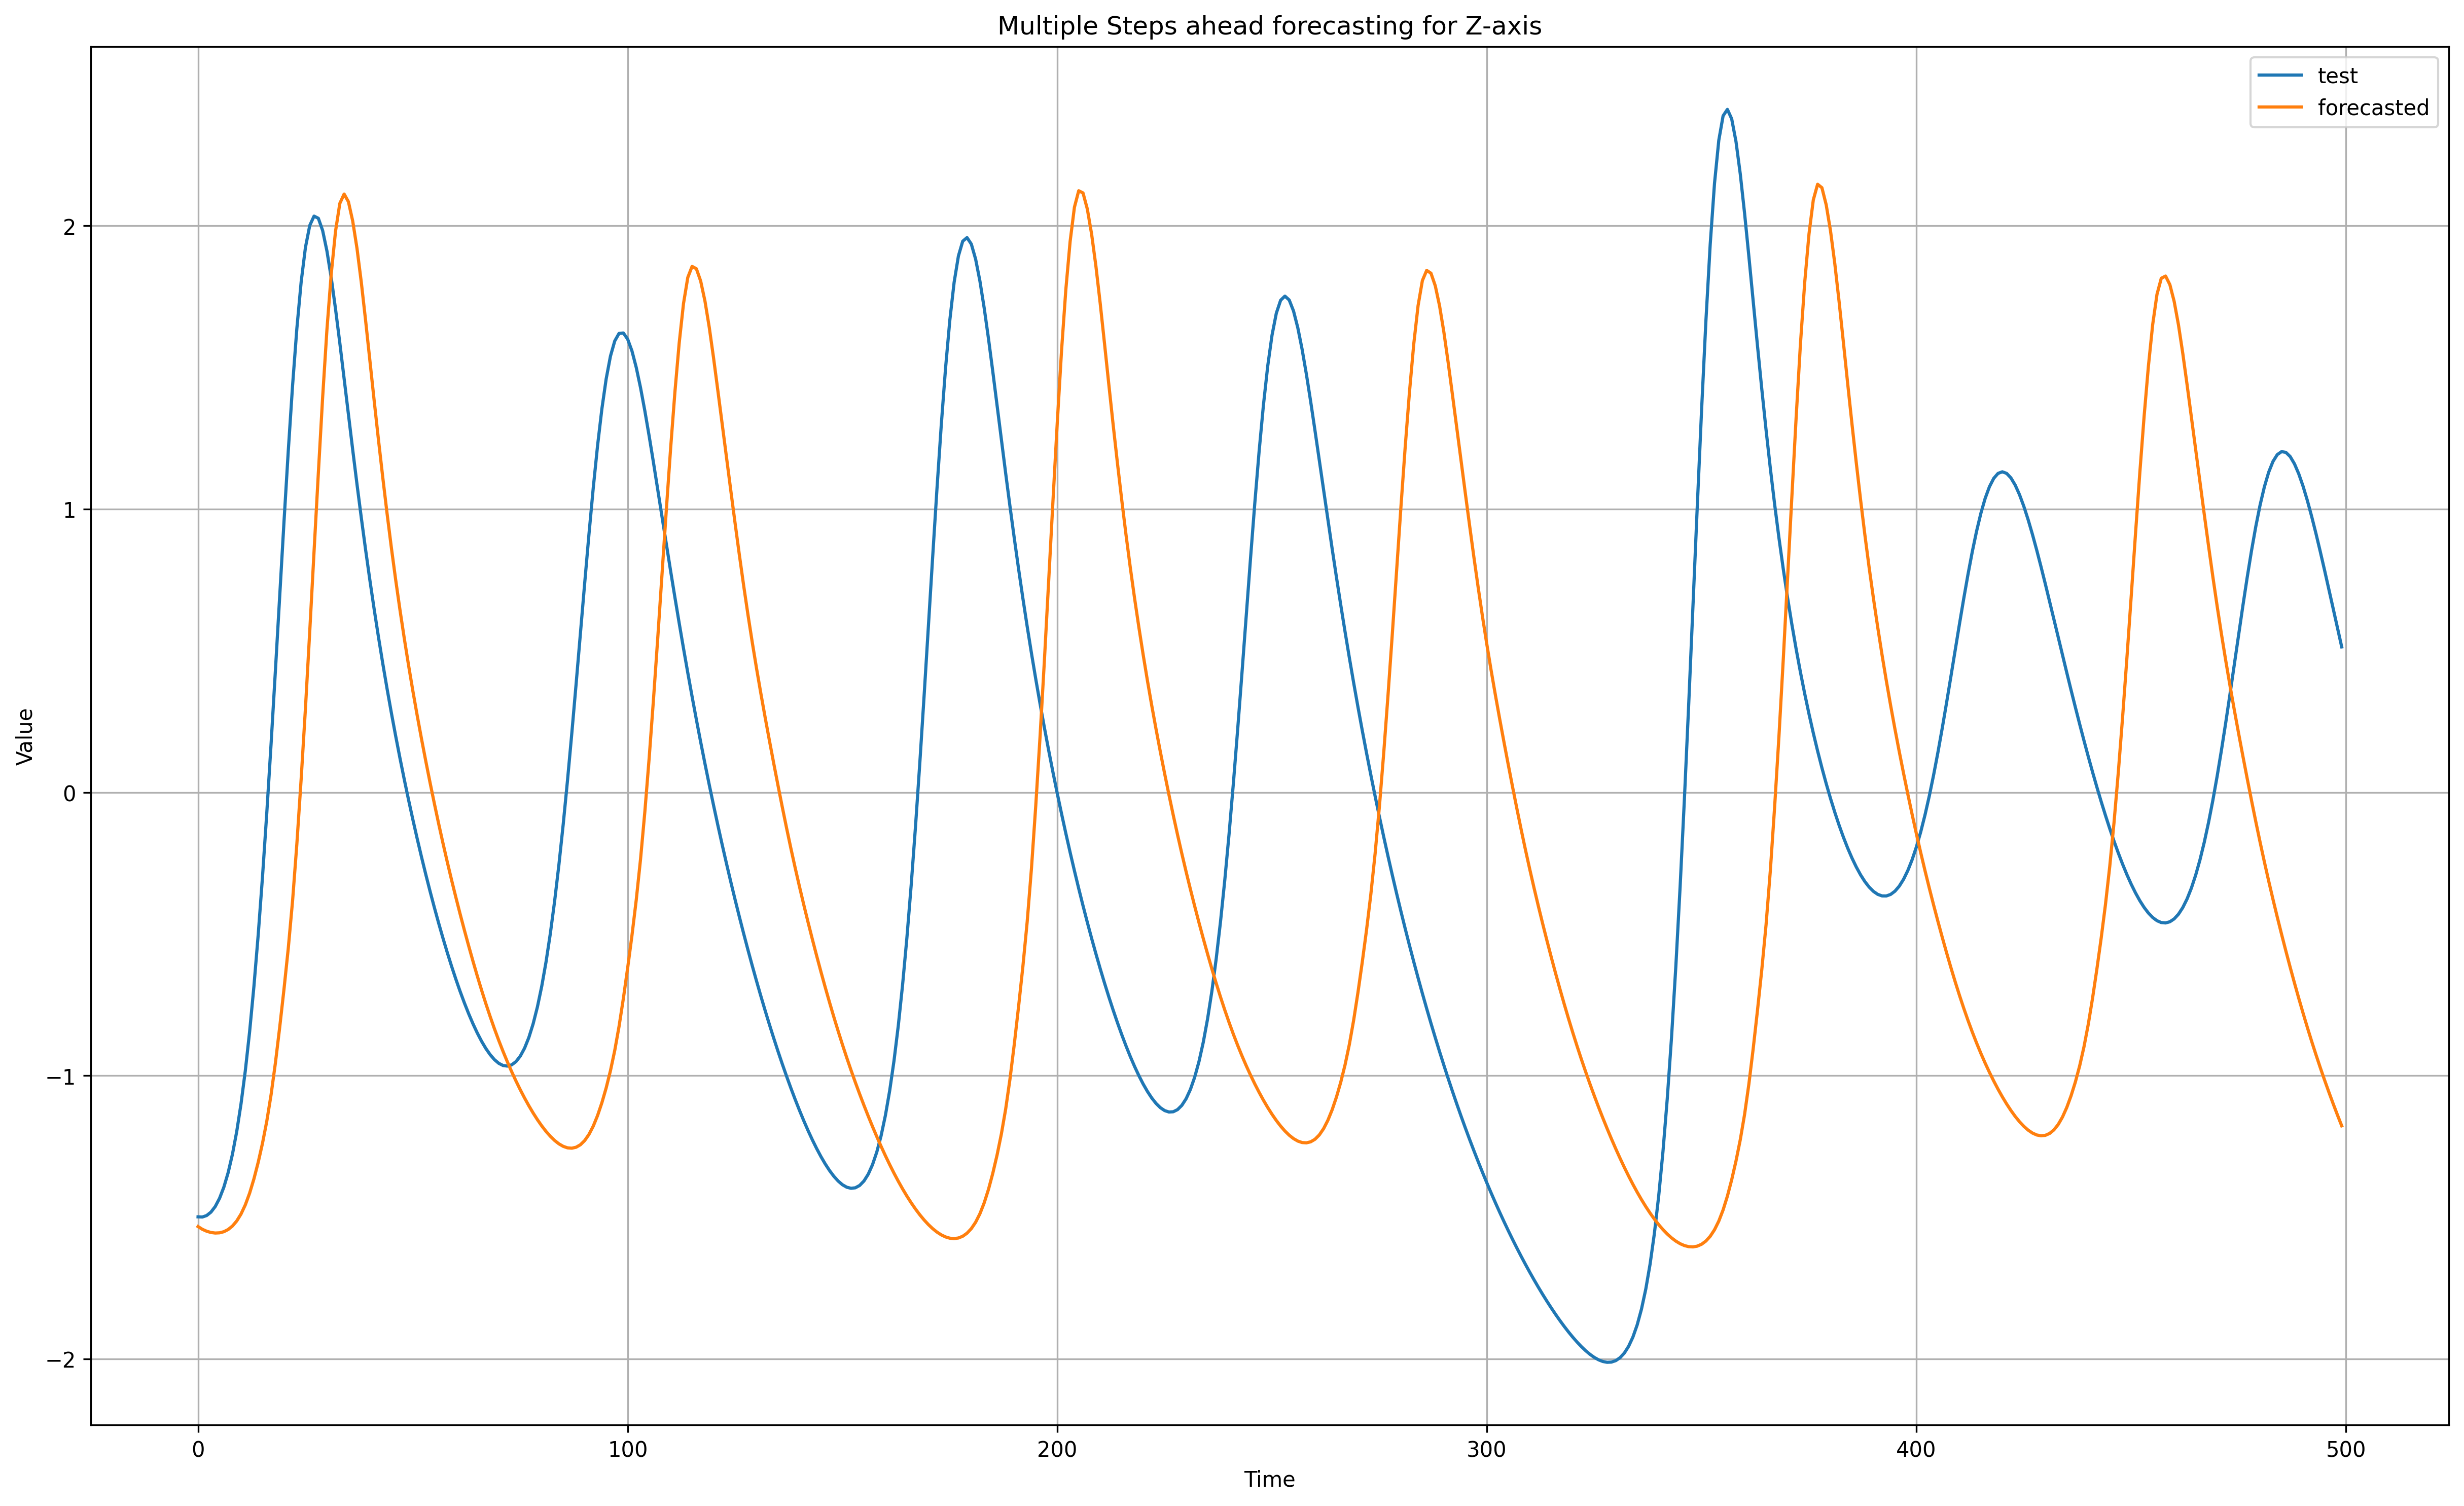

In [56]:
plt.figure(figsize=(20, 12), dpi=300)
plt.plot(test_Y[:forecast_time, 2], label='test')
plt.plot(Y_mult[:, 2], label='forecasted')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title('Multiple Steps ahead forecasting for Z-axis')
plt.grid(True)

# RNN Multiple output forecasting (We do not use it!)

In [ ]:
data.shape

(600000, 3)

Split sequence to get multiple output. Here output values will look like one string. For the first sample and for window_size = 100 and window_size_out = 50, each 50 values in Y will denotes to X(100)...X(150), Y(100)...Y(150) and Z(100)...Z(150) consequently.

In [ ]:
def split_sequence_mult(sequence, window_in, window_out):
    X, Y = list(), list()
    for i in range(0, len(sequence) - window_out - 1):
      end_ix = i + window_in
      if end_ix > len(sequence) - window_out - 1:
            break
      seq_x = sequence[i:end_ix, :]
      seq_y = sequence[end_ix: end_ix + window_out, 0]
      seq_y = np.append(seq_y, sequence[end_ix: end_ix + window_out,1])
      seq_y = np.append(seq_y, sequence[end_ix: end_ix + window_out,2])
      X.append(seq_x)
      Y.append(seq_y)
    return np.array(X), np.array(Y)

In [ ]:
window_size = 100
window_size_out = 50
X, Y = split_sequence_mult(data.values, window_size, window_size_out)
print(X.shape, Y.shape)

(599850, 100, 3) (599850, 150)


In [ ]:
end_train = int(np.round(X.shape[0]*0.6))
end_valid = int(np.round(X.shape[0]*(0.6+0.2)))
train_X = X[:end_train]
train_Y = Y[:end_train]
valid_X = X[end_train:end_valid]
valid_Y = Y[end_train:end_valid]
test_X = X[end_valid::20]
test_Y = Y[end_valid::20]

In [ ]:
print('Train X shape - ', train_X.shape, ' train Y shape - ', train_Y.shape)
print('Valid X shape - ', valid_X.shape, ' valid Y shape - ', valid_Y.shape)
print('Test X shape  - ', test_X.shape, '   test Y shape - ', test_Y.shape)

Train X shape -  (359910, 100, 3)  train Y shape -  (359910, 150)
Valid X shape -  (119970, 100, 3)  valid Y shape -  (119970, 150)
Test X shape  -  (5999, 100, 3)    test Y shape -  (5999, 150)


Define another model

In [ ]:
from keras import Model, layers, Input
from keras.optimizers import Adam
from keras import backend as K

In [ ]:
def build_lstm_model(input_shape, out_shape, summary=True):
    
    inputs = Input(shape=input_shape)
    
    x = layers.LSTM(50, activation='tanh', dropout=.2, return_sequences=True)(inputs)
    x = layers.LSTM(50, activation='tanh', dropout=.2)(x)
    output = layers.Dense(out_shape)(x)
    
    model = Model(inputs=inputs, outputs=output, name="lstm_model")
    model.compile(loss=root_mean_squared_error,
                optimizer="rmsprop",
                metrics=['accuracy'])
    if summary:
        print(model.summary())
    
    return model

In [ ]:
lstm_model = build_lstm_model((window_size,3), window_size_out*3)

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 3)]          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 50)           10800     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 150)               7650      
Total params: 38,650
Trainable params: 38,650
Non-trainable params: 0
_________________________________________________________________
None


Training

In [ ]:
lstm_history = lstm_model.fit(train_X, train_Y, epochs=25, batch_size=100)

Epoch 1/25
3600/3600 [==============================] - 45s 12ms/step - loss: 0.2679 - accuracy: 0.2773
Epoch 2/25
3600/3600 [==============================] - 42s 12ms/step - loss: 0.0998 - accuracy: 0.5199
Epoch 3/25
3600/3600 [==============================] - 42s 12ms/step - loss: 0.0791 - accuracy: 0.5884
Epoch 4/25
3600/3600 [==============================] - 42s 12ms/step - loss: 0.0680 - accuracy: 0.6371
Epoch 5/25
3600/3600 [==============================] - 41s 11ms/step - loss: 0.0606 - accuracy: 0.6737
Epoch 6/25
3600/3600 [==============================] - 42s 12ms/step - loss: 0.0552 - accuracy: 0.7010
Epoch 7/25
3600/3600 [==============================] - 42s 12ms/step - loss: 0.0506 - accuracy: 0.7244
Epoch 8/25
3600/3600 [==============================] - 42s 12ms/step - loss: 0.0468 - accuracy: 0.7405
Epoch 9/25
3600/3600 [==============================] - 42s 12ms/step - loss: 0.0439 - accuracy: 0.7548
Epoch 10/25
3600/3600 [==============================] - 41s 11m

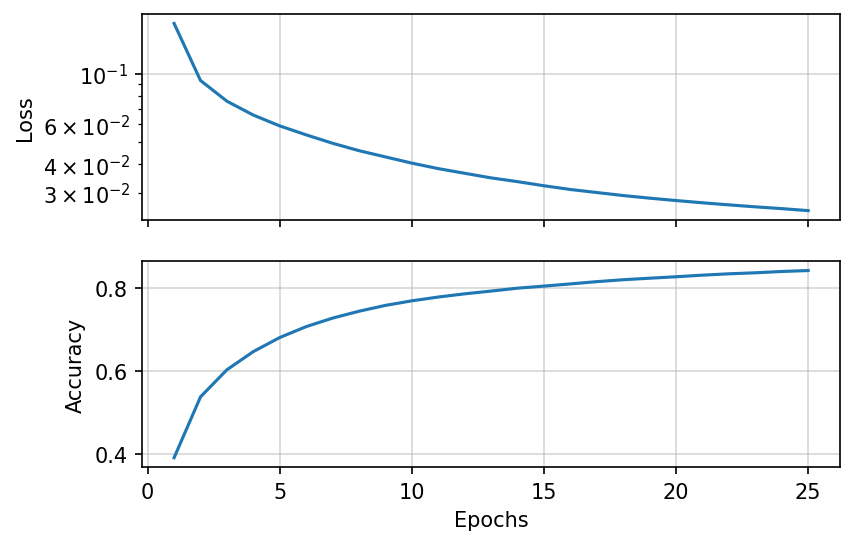

In [ ]:
from matplotlib import pyplot as plt

def plot_history(history, ylim=None):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  ax1.plot(np.array(history.epoch)+1, history.history['loss'])
  ax1.set_ylabel('Loss')
  ax1.set_yscale('log')
  ax1.grid(alpha=.5)
  if history.history.__contains__('lr'):
    ax1b = ax1.twinx()
    ax1b.plot(history.history['lr'], 'g-', linewidth=1)
    ax1b.set_yscale('log')
    ax1b.set_ylabel('Learning Rate', color='g')

  ax2.plot(np.array(history.epoch)+1, history.history['accuracy'])
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.grid(alpha=.5)
  if ylim:
    ax2.set_ylim(ylim)
  #ax2.legend()
  plt.show() 

plot_history(lstm_history)

Forecasting. Here we forecast window_size_out values at once

In [ ]:
selected = valid_Y
print(valid_Y.shape)

(119970, 150)


In [ ]:
forecast = lstm_model.predict(valid_X)
print(forecast.shape)

(119970, 150)


Calculate error for X, Y, Z for each timestep

In [ ]:
errorX, errorY, errorZ = list(), list(), list()
for i in range(window_size_out-1):
  errorX = np.append(errorX, tf.keras.metrics.mean_squared_error(selected[:, :i+1], forecast[:, :i+1]).numpy())
  errorY = np.append(errorY, tf.keras.metrics.mean_squared_error(selected[:, window_size_out+i+1:2*window_size_out+1], forecast[:, window_size_out+i+1:2*window_size_out+1]).numpy())
  errorZ = np.append(errorZ, tf.keras.metrics.mean_squared_error(selected[:, 2*window_size_out+i+1:], forecast[:, 2*window_size_out+i+1:]).numpy())

print('RMSE X =', errorX)
print('RMSE Y =', errorY)
print('RMSE Z =', errorZ)

RMSE X = [0.05245412 0.06454735 0.07639708 ... 0.04084559 0.04090364 0.04153446]
RMSE Y = [0.08509317 0.0888932  0.09415392 ... 0.22044986 0.26296142 0.30697978]
RMSE Z = [0.15391146 0.16006616 0.16679972 ... 0.04009002 0.03937078 0.03910062]


X = :window_size_out

Y = window_size_out:2*window_size_out

Z = 2*window_size_out:

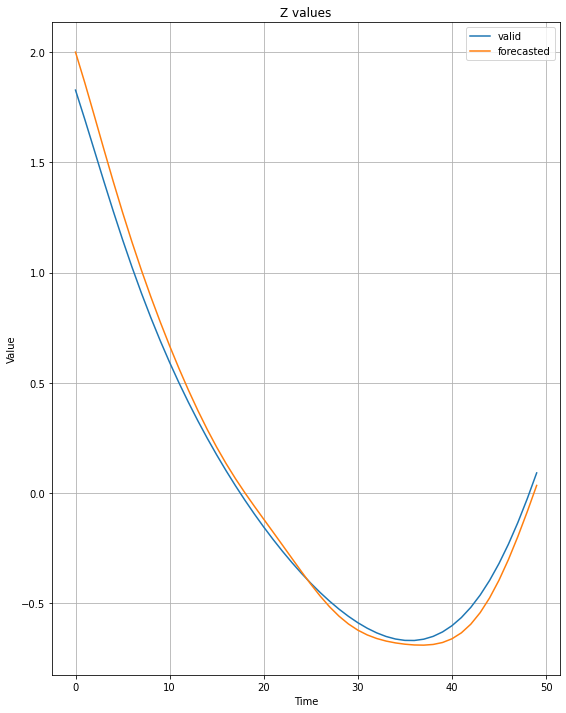

In [ ]:
plt.figure(figsize=(20, 12))
plt.subplot(1, 2, 1)
plt.plot(valid_Y[20, 2*window_size_out:], label='valid')
plt.plot(forecast[20, 2*window_size_out:], label='forecasted')
plt.legend()
plt.title('Z values')
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)